In [423]:
import numpy as np

from filterpy.monte_carlo import residual_resample

import cv2

from PIL import Image

import matplotlib.pyplot as plt

import glob

import math

import time

## Particle Filter class

In [424]:
class ParticleFilter():
    def __init__(self, fitness, transition, nfeatures=5,nparticles=100, distribution=None, mu = None, sigma = None, lb = None, ub = None):
        self.fitness = fitness
        self.transition = transition
        self.nfeatures = nfeatures
        self.nparticles = nparticles
        self.distribution = distribution
        self.mu = mu
        self.sigma = sigma
        self.lb = lb
        self.ub = ub
        self.initialize_particles()
    

    def initialize_particles(self):
        self.particles = []
        if(self.distribution):
            for i in range(self.nfeatures):
                if(self.distribution[i] == 'normal'):
                    self.particles.append(np.random.normal(size=(self.nparticles, 1), loc = self.mu[i], scale=self.sigma[i]))
                else:
                    self.particles.append(np.random.uniform(low = self.lb[i], high = self.ub[i], size=(self.nparticles, 1)))
        else:
            self.particles = np.random.normal(size=(self.nparticles, self.nfeatures))
            '''if(self.sigma): 
                self.particles *= self.sigma
            if(self.mu):
                self.particles += self.mu'''
            
        self.particles = np.array(self.particles).reshape(self.nfeatures,self.nparticles)
        self.particles = np.swapaxes(self.particles, 0, 1)
        if(self.lb):
            self.particles = np.clip(self.particles, self.lb, np.inf)
        if(self.ub):
            self.particles = np.clip(self.particles, -np.inf, self.ub)
        self.weights = np.zeros(shape=(self.nparticles))

    
    def return_particles(self):
        return self.particles
    def return_20_mean(self):
        idx = np.argpartition(self.weights, int(self.nparticles * 0.8))

        return np.average(self.particles[idx[int(self.nparticles * 0.8):]], weights = self.weights[idx[int(self.nparticles * 0.8):]], axis = 0)
    def return_best_mean(self, value = 0.95):
        idx = np.argpartition(self.weights, int(self.nparticles * 0.95))
        #plt.plot(self.weights[idx[int(self.nparticles * 0.95):]])
        
        return np.average(self.particles[idx[int(self.nparticles * 0.95):]], weights = self.weights[idx[int(self.nparticles * 0.95):]], axis = 0)

    def return_mean(self):
        return np.mean(self.particles, axis= 0)

    def predict(self, u):
        self.particles = self.transition(self.particles, u)



    def update(self, observation):
        self.weights = self.fitness(self.particles, observation)
        self.weights += 1.e-20
        self.weights /= np.sum(self.weights)
    
    def resample(self):
        indexes = residual_resample(self.weights)
        self.particles = self.particles[indexes,:]
        self.weights = self.weights[indexes]

    


    def next_step(self, observation, u):
        self.predict(u)
        self.update(observation)
        self.resample()

        




## Declare application-specific PF functions

In [425]:
# considering a particle = [h, l, rw, rd]

def transition(particles, u):
    dx = u[0]
    dh = u[1]
    particles[:,0] = np.clip(particles[:,0] + dh + np.random.normal(loc=0.0, scale=0.01,size=particles[:,0].shape), - 30 * np.pi/180, 30 * np.pi/180)
    particles[:,1] = particles[:,1] + dx * np.sin(particles[:,0]) + np.random.normal(loc=0.0, scale=0.1,size=particles[:,1].shape)
    particles[:,2] = np.clip(particles[:,2] + np.random.normal(loc=0.0, scale=10,size=particles[:,2].shape), 0, np.inf)
    particles[:,3] = np.clip(particles[:,3] + np.random.normal(loc=0.0, scale=10,size=particles[:,3].shape), 0, np.inf)
    return particles


def create_masks(particles, observation, plot = 0):
    masks = []
    shape = observation.shape
    value = 200
    shape = (shape[0], shape[1] + value)
    for particle in particles:
        aux = np.zeros(shape)
        central_x = shape[1]//2
        mean_l = central_x - particle[2]//2 + particle[1]
        mean_r = central_x + particle[2]//2 + particle[1]
        left_l = np.clip(mean_l - particle[3]//2, 0, shape[1])
        right_l = np.clip(mean_l + particle[3]//2, 0, shape[1])
        left_r = np.clip(mean_r - particle[3]//2, 0, shape[1])
        right_r = np.clip(mean_r + particle[3]//2, 0, shape[1])

        aux[:,int(left_l):int(right_l)] = 1
        aux[:,int(left_r):int(right_r)] = 1
        if(plot):
            aux = 1-aux

        aux = skew_image(aux, int(particle[0] * 4 * 180./np.pi))


        aux = aux[:, value/2:shape[1]-value/2]

        masks.append(aux)
    return np.array(masks)

def skew_image(image, value = 0):

    IMAGE_H = image.shape[0]
    IMAGE_W = image.shape[1]
    
    #aa = 250 + value
    #bb = 400 + value

    #src = np.float32([[200, IMAGE_H], [450, IMAGE_H], [0, 0], [IMAGE_W, 0]])
    #dst = np.float32([[aa, IMAGE_H], [bb, IMAGE_H], [0, 0], [IMAGE_W, 0]])

    value = value * (IMAGE_W + IMAGE_H)/400.
    aa = 100./400*IMAGE_W + value 
    bb = 300./400*IMAGE_W + value 

    src = np.float32([[40, IMAGE_H], [360, IMAGE_H], [0, 0], [IMAGE_W, 0]])
    ###src = np.float32([[40, IMAGE_H], [160, IMAGE_H], [0, 0], [IMAGE_W, 0]])
    dst = np.float32([[aa, IMAGE_H], [bb, IMAGE_H], [0, 0], [IMAGE_W, 0]])

    src = np.float32([[40./400 * IMAGE_W, 0], [360./400 * IMAGE_W, 0], [0, IMAGE_H], [IMAGE_W, IMAGE_H]])
    dst = np.float32([[aa, 0], [bb, 0], [0, IMAGE_H], [IMAGE_W, IMAGE_H]])

    #src = np.float32([[20, 0], [180, 0], [0, IMAGE_H], [IMAGE_W, IMAGE_H]])
    #src = np.float32([[40, IMAGE_H], [160, IMAGE_H], [0, 0], [IMAGE_W, 0]])
    #dst = np.float32([[aa, 0], [bb, 0], [0, IMAGE_H], [IMAGE_W, IMAGE_H]])




    '''
    aa = 50
    bb = 150
    src = np.float32([[aa, IMAGE_H], [bb, IMAGE_H], [0, 0], [IMAGE_W, 0]])
    dst = np.float32([[20, IMAGE_H], [180, IMAGE_H], [0+value, 0], [IMAGE_W+value, 0]])
    '''

    M = cv2.getPerspectiveTransform(src, dst) 
    Minv = cv2.getPerspectiveTransform(dst, src) 

    warped_img = cv2.warpPerspective(image, M, (IMAGE_W, IMAGE_H))
    
    return warped_img

'''
def atenuation_factor(weights):
    idx = np.argpartition(weights, 20)
    weights[idx] *= 0.2
    return weights
'''

def fitness(particles, observation):
    pred = create_masks(particles, observation)
    observation /= np.max(observation)
    observation = observation[None, :].astype(np.float32)
    intersection = observation * pred
    notObservation = 1 - observation
    union = observation + (notObservation * pred)

    #print(intersection.shape)

    result = (np.sum(intersection, axis=(-1,-2)) + 1.e-100) / (np.sum(union, axis=(-1,-2)) + 1.e-100)

    #result = atenuation_factor(result)
    return result



## Declare segmentation functions

In [426]:
def exg(im_to_binarize):
    im_to_binarize = im_to_binarize.astype(np.float)
    R_ = im_to_binarize[:,:,2]/np.max(im_to_binarize[:,:,2])
    G_ = im_to_binarize[:,:,1]/np.max(im_to_binarize[:,:,1])
    B_ = im_to_binarize[:,:,0]/np.max(im_to_binarize[:,:,0])
    
    r = R_/(R_+G_+B_)
    g = G_/(R_+G_+B_)
    b = B_/(R_+G_+B_)
    
    excess_red = 1.4*r - g
    excess_green = 2*g - r - b
    return excess_green


def exg_th(img, th = [0., 0.5]):
    a = exg(img)
    b = np.zeros(shape = a.shape)
    b[a<th[0]] = 0
    b[(a>=th[0]) & (a < th[1])] = (a[(a>=th[0]) & (a < th[1])] - th[0])/(th[1] - th[0])
    b[a >= th[1]] = 1
    return b
    

#### trash

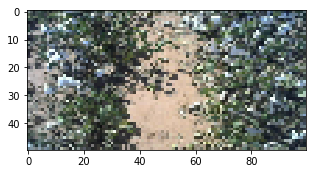

In [427]:


image = np.array(Image.open('nav_front/frame_21.jpg'))

image_rs = cv2.resize(image,(100,50))

plt.figure(figsize=(5,5))
plt.imshow(image_rs)



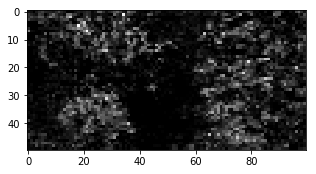

In [428]:
mask_show = exg_th(image_rs) # [0.05, 0.1]

plt.figure(figsize=(5,5))
plt.imshow(mask_show, cmap='gray')


## Plot Helper Functions

In [429]:

def blend_images(rgb, mask):
    aux = cv2.merge([mask * 255, np.zeros(mask.shape), np.zeros(mask.shape)])
    aux = aux.astype(np.uint8)

    return cv2.addWeighted(rgb, 1, aux, 5, 0.0)

def draw_arrow(image, l, h, scale = 1):
    pt1 = (int(image.shape[1]/2 + l*scale), image.shape[0])
    pt2 = (int(image.shape[1]/2 + l*scale + image.shape[1]/2 * math.tan(h)), image.shape[0]/2)

    cv2.arrowedLine(image, pt1, pt2,(0,0,255), 4)
    return image


def blend_images_big(rgb,mask):
    aux = cv2.merge([mask * 255, np.zeros(mask.shape), np.zeros(mask.shape)])
    aux = cv2.resize(aux, (rgb.shape[1],rgb.shape[0]))
    aux = aux.astype(np.uint8)

    return cv2.addWeighted(rgb, 1, aux, 5, 0.0)


#### trash

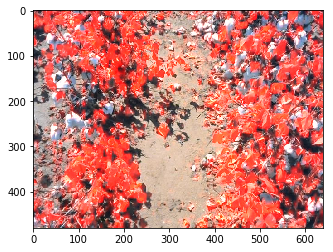

In [430]:
plt.imshow(blend_images_big(image,mask_show))

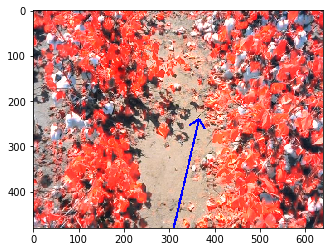

In [431]:
plt.imshow(draw_arrow(blend_images_big(image,mask_show), -10, 10./180*math.pi))

# It's time to test the algorithm on real images
## Create an object of PF class and Initilize Particles

In [439]:
process_image_size = (200,50)
max_lateral_offset = process_image_size[0]/2
max_row_width = process_image_size[0]
max_row_distance = process_image_size[0]

mean_row_width = process_image_size[0]/2
mean_row_distance = process_image_size[0]/2

nparticles = 100

In [440]:
pf = ParticleFilter(transition = transition, fitness = fitness, nfeatures=4, mu = [0,0,0,0], sigma = [1,10,0,0], lb = [-np.pi/2, -max_lateral_offset, 0, 0], ub=[np.pi/2, max_lateral_offset, max_row_width, max_row_distance], nparticles = nparticles, distribution=['normal','normal','uniform','uniform'])

## Find and sort all image paths

In [441]:
images = ['nav_front/frame_' + str(a) + '.jpg' for a in range(len(glob.glob('nav_front/*.jpg')))]



## Open file, calculate particle filter posterior probabilities and draw the results

In [442]:
best_particles = []

lateral_offsets = []
headings = []
times = []

for image_path in images:
    image = np.array(Image.open(image_path))
    
    measure_time = time.time()

    image_rs = cv2.resize(image,process_image_size)
    mask = exg_th(image_rs)
    pf.next_step(mask, [0.1,0]) # I dont know the input on each image, so I will let it be [0.1,0] for now

    best_particle = pf.return_best_mean()

    times.append(time.time() - measure_time)
    best_particles.append(best_particle)
    mask_best_particle = create_masks([best_particle], mask, plot = 1)[0]

    headings.append(best_particle[0])
    lateral_offsets.append(best_particle[1])

    blended_image = draw_arrow(blend_images_big(image, mask_best_particle), best_particle[1], best_particle[0], float(image.shape[1])/mask.shape[1]) 

    plt.imsave('pf_output/' + image_path.split('/')[1], blended_image)
    





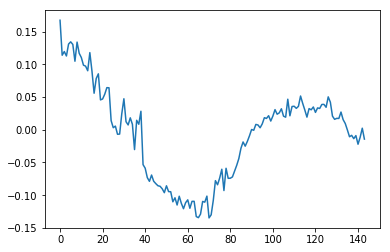

In [422]:
plt.plot(headings)

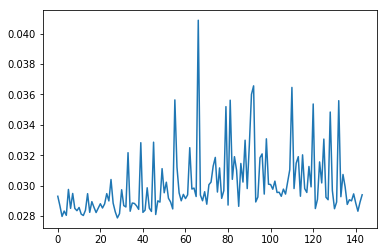

In [411]:
plt.plot(times)

In [337]:
1./np.mean(times)

33.17918281550834

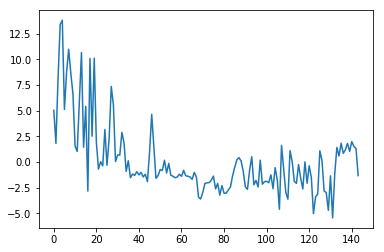

In [412]:
plt.plot([a * float(image.shape[1] / mask.shape[1]) for a in lateral_offsets])

In [241]:
float(image.shape[1])/mask.shape[1]

3.2

In [233]:
import json

data = {'headings': headings, 'lateral_offsets': lateral_offsets}

with open('dados.json', 'w') as f:
    json.dump(data, f)

In [239]:

with open('dados.json') as f:
    data2 = json.load(f)

h = data2['headings']
l = data2['lateral_offsets']



### Make Video

In [217]:
img_array = []
for image_path in images:
    img = cv2.imread('pf_output/' + image_path.split('/')[1])
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
 
 
out = cv2.VideoWriter('video.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

### more trash

In [104]:
particle = best_particles[37][:]
print(particle)

[ 1.76877083e-02 -1.04180247e+01  3.48941676e+02  2.92071395e+02]


-0.1


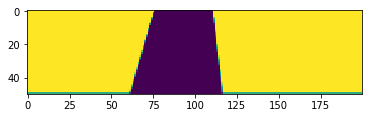

In [414]:
print(particle[0])
particle[0] = -0.
plt.imshow(create_masks([particle], mask)[0])

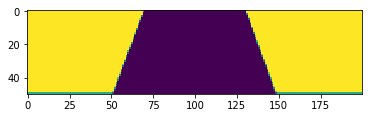

In [415]:
asd = best_particles[35][:]
asd[0] = 0
plt.imshow(create_masks([asd], mask)[0])